# Selbstversorger Österreich? Ein Überblick über landwirtschaftliche Erzeugnisse in Österreich

Mit den letzten Krisen und Katastrophen wurde unserer Gesellschaft vor Augen gehalten, dass wir uns nicht immer auf Lieferketten verlassen können. Wichtige Schiffsruten können von stecken gebliebenen Schiffen blockiert werden. Ein Virus kann die Arbeiter in Massen arbeitsunfähig werden lassen. Spannung zwischen Staaten können plötzlich sicher geglaubte Rohstoffquellen unerreichbar machen. Gerade Lebensmittel spielen hier eine zentrale Rolle. Die Nachfolgende Analyse soll Aufschluss geben wie viel landwirdschaftliche Erzeugnisse in Österreich erzeugt werden. Ein besonderes Augenmerk wird auch auf die einzelnen Bundesländer gelegt.

## Datenquellen

### Bevölkerungsdaten

Um Berechnungen pro Kopf in Österreich und je Bundesland durchführen zu können, werden Bevölkerungsdaten benötigt. Dazu wurde eine Rest API von EuroStat abgerufen.

### Produktionswert des landwirtschaftlichen Wirtschaftsbereichs

Um genaue Daten bezüglich der landwirtschaftlichen Produktion in Österreich verarbeiten zu können wurden Informationen der Statistk Austria herangezogen und als .ods File eingespielt.

## Notwendige Installs and Imports

In [1]:
!pip install psycopg2-binary pandas matplotlib seaborn requests
!pip install pandas-ods-reader

In [2]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_ods_reader import read_ods

## Bevölkerungsdaten

In [3]:
# API abrufen
url_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_r_d2jan?format=JSON&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=NR&sex=T&age=TOTAL&lang=en"
response = requests.get(url_population)
data = response.json()

# Überprüfen der Datenstruktur
#print(data.keys())
#print(data)

In [4]:
pd.set_option('display.max_rows', None)
years = data['dimension']['time']['category']['label'].keys()
regions = []
geocodes = []

for x in data['dimension']['geo']['category']['label'].values():
    for y in range(5):
        regions.append(x)

for x in data['dimension']['geo']['category']['label'].keys():
    for y in range(5):
        geocodes.append(x)

# Erstellen eines DataFrames
population = pd.DataFrame(
                          {'GeoCode' : geocodes,
                           'Region' : regions,
                           'Year': list(years) * 13,
                          'Population': list(data['value'].values())
                          }
                         )


In [5]:
print(data['dimension']['geo']['category']['label'].values())

dict_values(['Austria', 'Ostösterreich', 'Burgenland', 'Niederösterreich', 'Wien', 'Südösterreich', 'Kärnten', 'Steiermark', 'Westösterreich', 'Oberösterreich', 'Salzburg', 'Tirol', 'Vorarlberg'])


EuroStat stellt sehr detaillierte Bevökerungsdaten zur Verfügung. Neben Österreich und den Bundesländern, gibt es auch eine Unterteilung nach Ostösterreich, Südösterreich und Westösterreich. Für die folgende Analyse sind diese Informationen aber nicht notwendig. Deswegen werden diese Daten ignoriert.

In [6]:
population = population.loc[(population['Region']!='Südösterreich') & (population['Region']!='Ostösterreich') & ((population['Region']!='Westösterreich'))]

In [7]:
print(years)

dict_keys(['2019', '2020', '2021', '2022', '2023'])


Weiters haben wir den Zeitraum 2019-2023 in den Daten abgebildet. Für 2023 gab es zum Zeitpunk der Erstellung dieser Analyse noch keine Daten der Statistik Austria bezüglich der landwirtschaftlichen Produktion in Österreich. Deswegen werden auch diese Daten herausgenommen.

In [8]:
population = population.loc[(population['Year']!='2023')]

Der gesamte angepasste Datensatz sieht nun folgendermaßen aus:

In [9]:
print(population)

   GeoCode            Region  Year  Population
0       AT           Austria  2019     8858775
1       AT           Austria  2020     8901064
2       AT           Austria  2021     8932664
3       AT           Austria  2022     8978929
10    AT11        Burgenland  2019      293433
11    AT11        Burgenland  2020      294436
12    AT11        Burgenland  2021      296010
13    AT11        Burgenland  2022      297583
15    AT12  Niederösterreich  2019     1677542
16    AT12  Niederösterreich  2020     1684287
17    AT12  Niederösterreich  2021     1690879
18    AT12  Niederösterreich  2022     1698796
20    AT13              Wien  2019     1897491
21    AT13              Wien  2020     1911191
22    AT13              Wien  2021     1920949
23    AT13              Wien  2022     1931593
30    AT21           Kärnten  2019      560939
31    AT21           Kärnten  2020      561293
32    AT21           Kärnten  2021      562089
33    AT21           Kärnten  2022      564513
35    AT22   

### Deskriptive Auswertung

In [10]:
print(population.loc[population['GeoCode'] == 'AT'])

  GeoCode   Region  Year  Population
0      AT  Austria  2019     8858775
1      AT  Austria  2020     8901064
2      AT  Austria  2021     8932664
3      AT  Austria  2022     8978929


Die österreichische Bevökerung ist eine stetig wachsende. Bereits 2022 waren es nur knapp unter 9 Millionen Menschen. Tendenz ganz klar steigend! 

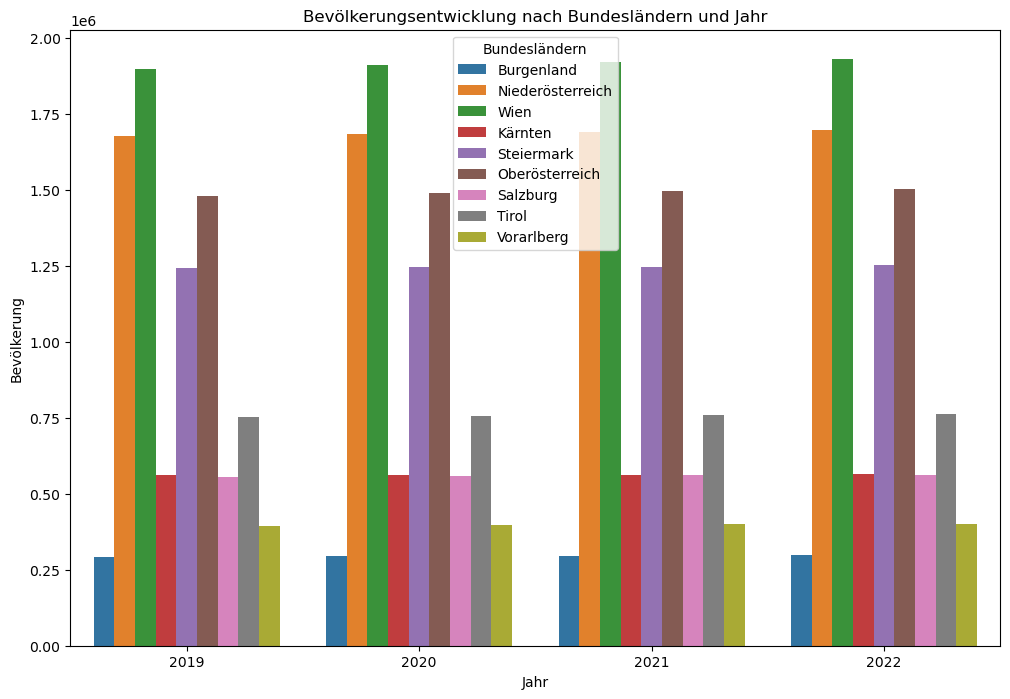

In [11]:
# Erstellen eines Balkendiagramms zur Visualisierung der Bevölkerung nach GeoCode und Jahr
plt.figure(figsize=(12, 8))
sns.barplot(data=population.loc[population['GeoCode'] != 'AT'], x='Year', y='Population', hue='Region')
plt.title('Bevölkerungsentwicklung nach Bundesländern und Jahr')
plt.xlabel('Jahr')
plt.ylabel('Bevölkerung')
plt.legend(title='Bundesländern')
plt.show()


Ein Blick auf die Bundesländer bestätigt dies. Bemerkenswert ist auch ein gleichmäßiger Anstieg aller Regionen. Keine sticht durch besonders steigende oder fallende Bevölkerungszahlen auf.

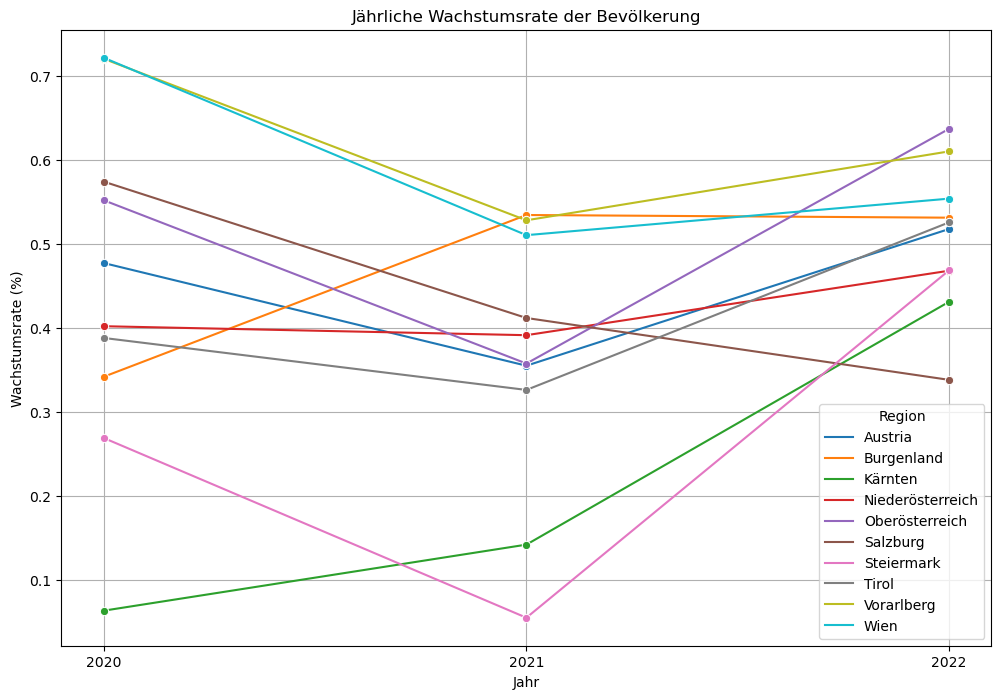

In [12]:
# Berechnung der jährlichen Wachstumsrate der Bevölkerung pro GeoCode
population_sorted = population.sort_values(by=['Region', 'Year'])
population_sorted['Population_Growth'] = population_sorted.groupby('Region')['Population'].pct_change() * 100

# Visualisierung der Wachstumsraten
plt.figure(figsize=(12, 8))
sns.lineplot(data=population_sorted, x='Year', y='Population_Growth', hue='Region', marker='o')
plt.title('Jährliche Wachstumsrate der Bevölkerung')
plt.xlabel('Jahr')
plt.ylabel('Wachstumsrate (%)')
plt.grid(True)
plt.show()


Der prozentuelle Anstieg macht auch noch einmal deutlich, dass in allen Bundesländer (und dadurch auch gesamt Österreich) die Bevölkerung sehr gleichmäßig steigt (realtiv zur Bevölkerungszahl). 

## Produktionsdaten von landwirtschaftlichen Gütern

In [13]:
pd.set_option('display.max_rows', 5)
agrar_data_2019 = read_ods("./ProduktionswertDetailRLGR.ods", '2019')
agrar_data_2019 = agrar_data_2019.assign(Year='2019')

agrar_data_2020 = read_ods("./ProduktionswertDetailRLGR.ods", '2020')
agrar_data_2020 = agrar_data_2020.assign(Year='2020')

agrar_data_2021 = read_ods("./ProduktionswertDetailRLGR.ods", '2021')
agrar_data_2021 = agrar_data_2021.assign(Year='2021')

agrar_data_2022 = read_ods("./ProduktionswertDetailRLGR.ods", '2022')
agrar_data_2022 = agrar_data_2022.assign(Year='2022')

agrar_data = pd.concat([agrar_data_2019,agrar_data_2020,agrar_data_2021,agrar_data_2022])

print(agrar_data)

                                              Merkmal       Bgld.        Ktn.  \
0                                            Getreide   87.661447   32.493403   
1                              Ölsaaten und Ölfrüchte   46.379612    4.496119   
..                                                ...         ...         ...   
27  Erzeugung des landwirtschaftlichen Wirtschafts...  648.639931  572.820731   
28  Q: STATISTIK AUSTRIA, Regionale landwirtschaft...         NaN         NaN   

             NÖ           OÖ        Sbg.        Stmk.           T        Vbg.  \
0    374.703687   203.097834    1.090793   100.139323    0.529796    0.144462   
1     89.013835    30.998401    0.055127    22.313484    0.010916    0.003894   
..          ...          ...         ...          ...         ...         ...   
27  3558.162694  2554.806727  465.883570  1880.916299  532.433870  219.819023   
28          NaN          NaN         NaN          NaN         NaN         NaN   

             W            

Auch diese Datenquelle stellt eine Vielzahl an Informationen bereit, nicht alle werden für die weitere Analyse verwendet. Die Bezeichnungen der Bundesländer werden zuerst angepasst um Verwirrungen zu vermeiden.

In [14]:
agrar_data.rename(columns = {'Ö':'Austria','W':'Wien','Bgld.':'Burgenland', 'Ktn.':'Kärnten', 'NÖ':'Niederösterreich', 'OÖ':'Oberösterreich', 'Sbg.':'Salzburg', 'Stmk.':'Steiermark', 'Vbg.':'Vorarlberg','T':'Tirol'  }, inplace = True)
print(agrar_data)

                                              Merkmal  Burgenland     Kärnten  \
0                                            Getreide   87.661447   32.493403   
1                              Ölsaaten und Ölfrüchte   46.379612    4.496119   
..                                                ...         ...         ...   
27  Erzeugung des landwirtschaftlichen Wirtschafts...  648.639931  572.820731   
28  Q: STATISTIK AUSTRIA, Regionale landwirtschaft...         NaN         NaN   

    Niederösterreich  Oberösterreich    Salzburg   Steiermark       Tirol  \
0         374.703687      203.097834    1.090793   100.139323    0.529796   
1          89.013835       30.998401    0.055127    22.313484    0.010916   
..               ...             ...         ...          ...         ...   
27       3558.162694     2554.806727  465.883570  1880.916299  532.433870   
28               NaN             NaN         NaN          NaN         NaN   

    Vorarlberg        Wien       Austria  Year  
0

Die Analysen beziehen sich expliziet auf tierische und pflanzliche Erzeugungen. Somit nehmen wir diese mit ihrer Summe (Erzeugung landwirtschaftlicher Güter) heraus.

In [15]:
agrar_data = agrar_data.loc[(agrar_data['Merkmal']=='Pflanzliche Erzeugung') | (agrar_data['Merkmal']=='Tierische Erzeugung') | (agrar_data['Merkmal']=='Erzeugung landwirtschaftlicher Güter') ]

In [16]:
pd.set_option('display.max_rows', 10)
print(agrar_data)
#print(agrar_data.loc[agrar_data['Merkmal']=='Erzeugung landwirtschaftlicher Güter'].groupby.sum())

                                 Merkmal  Burgenland     Kärnten  \
14                 Pflanzliche Erzeugung  366.034762  113.992776   
22                   Tierische Erzeugung   61.115925  259.229473   
23  Erzeugung landwirtschaftlicher Güter  427.150687  373.222249   
14                 Pflanzliche Erzeugung  395.524565  121.842681   
22                   Tierische Erzeugung   62.108900  253.124314   
..                                   ...         ...         ...   
22                   Tierische Erzeugung   64.641866  260.800767   
23  Erzeugung landwirtschaftlicher Güter  521.590368  411.168947   
14                 Pflanzliche Erzeugung  538.045592  186.366309   
22                   Tierische Erzeugung   75.113576  299.226570   
23  Erzeugung landwirtschaftlicher Güter  613.159168  485.592879   

    Niederösterreich  Oberösterreich    Salzburg   Steiermark       Tirol  \
14       1318.478579      562.914501   66.259414   514.063712   92.204247   
22        849.162674     1095

### Deskriptive Auswertung

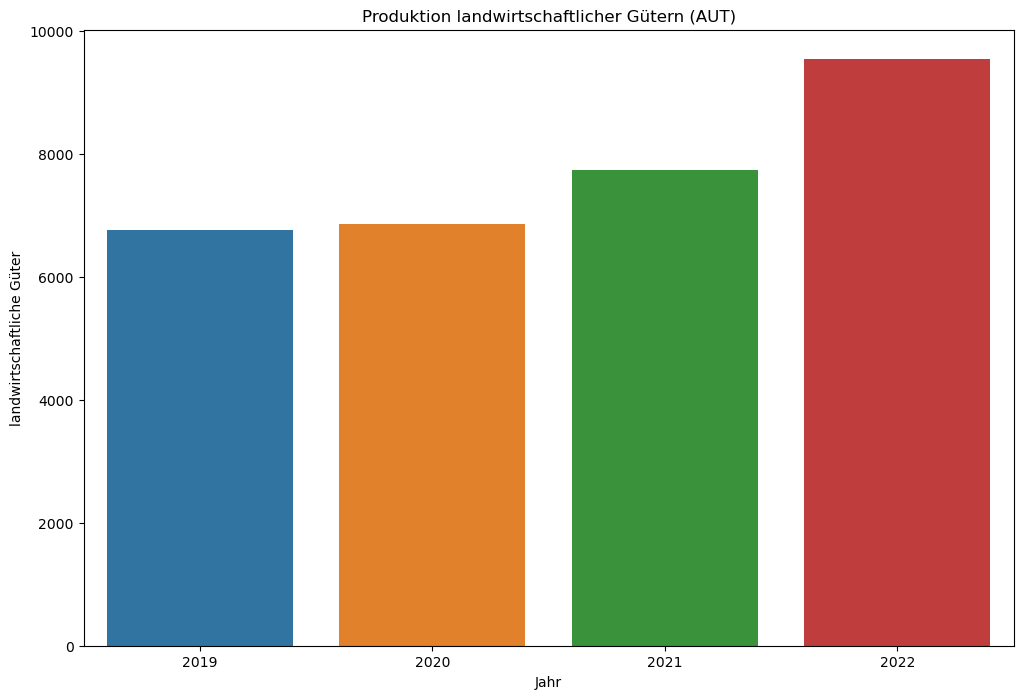

In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(data=agrar_data.loc[agrar_data['Merkmal']=='Erzeugung landwirtschaftlicher Güter'], x='Year', y='Austria')
plt.title('Produktion landwirtschaftlicher Gütern (AUT)')
plt.xlabel('Jahr')
plt.ylabel('landwirtschaftliche Güter')
plt.show()

Es ist klar zu sehen, dass auch die landwritschaftliche Produktion stetig steigt. Gerade im letzten Jahr dieser Analyse ist ein starker Anstieg zu erkennen.

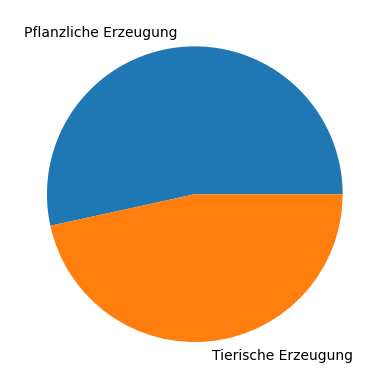

In [18]:
plant_animal_2022 = agrar_data.loc[((agrar_data['Merkmal']=='Pflanzliche Erzeugung')|(agrar_data['Merkmal']=='Tierische Erzeugung'))&(agrar_data['Year']=='2022')]
plt.pie(plant_animal_2022['Austria'], labels = plant_animal_2022['Merkmal'])
plt.show() 

Auch wenn in Österreich sowohl pflanzliche als auch tierische Erzeugnisse eine bedeutende Rolle in der heimischen Produktion spielen, nehmen die pflanzlichen den größeren Teil ein.

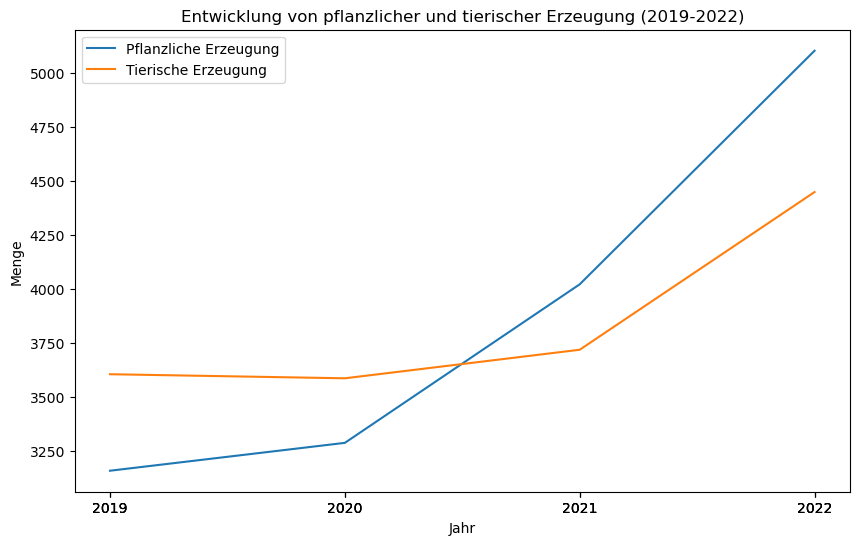

In [19]:
plt.figure(figsize=(10, 6))

pflanzliche_erzeugung = agrar_data[agrar_data['Merkmal'] == 'Pflanzliche Erzeugung']
tierische_erzeugung = agrar_data[agrar_data['Merkmal'] == 'Tierische Erzeugung']

plt.plot(pflanzliche_erzeugung['Year'], pflanzliche_erzeugung['Austria'], label='Pflanzliche Erzeugung')
plt.plot(tierische_erzeugung['Year'], tierische_erzeugung['Austria'], label='Tierische Erzeugung')

plt.title('Entwicklung von pflanzlicher und tierischer Erzeugung (2019-2022)')
plt.xlabel('Jahr')
plt.ylabel('Menge')
plt.xticks(agrar_data['Year'])
plt.legend()
plt.show()

Bei einem Blick auf die Entwicklung der beiden Daten in den letzten Jahren wird jedoch deutlich, dass dies einem Wandel unterliegt und erst seit 2021 die tierischen Erzeugnisse stärker als die pflanzlichen vertreten sind, bis 2020 war es noch anders herum.

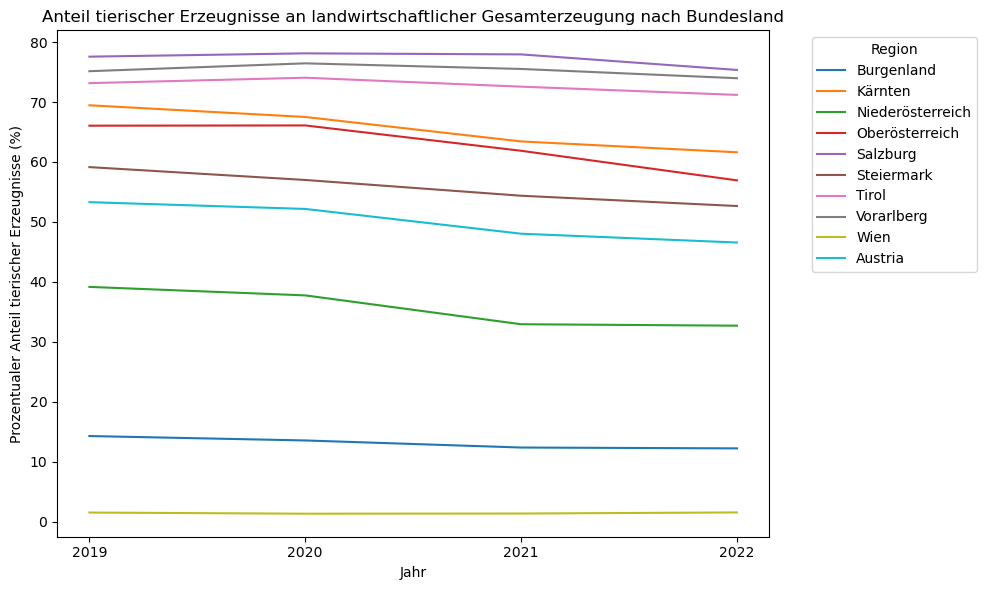

In [20]:
#Leeren Array für die Prozentuellen Daten anlegen
percentage = []

for column in agrar_data.columns[1:-1]:
    for year in agrar_data['Year'].unique():
        #Array mit den einzelnen Werten befüllen
        tierisch = agrar_data[(agrar_data['Merkmal'] == 'Tierische Erzeugung') & (agrar_data['Year'] == year)][column].values[0]
        total = agrar_data[(agrar_data['Merkmal'] == 'Erzeugung landwirtschaftlicher Güter') & (agrar_data['Year'] == year)][column].values[0]
        percentage_tierisch = (tierisch / total) * 100
        percentage.append([percentage_tierisch,{column},{year}])

#Array in DataFrame umwandeln und Regions und Jahrdaten analysierbar machen.
percentage_df = pd.DataFrame(percentage, columns=['Percentage_Tierisch', 'Region', 'Year'])

percentage_df['Region'] = percentage_df['Region'].apply(lambda x: list(x)[0])
percentage_df['Year'] = percentage_df['Year'].apply(lambda x: list(x)[0])

regionen = percentage_df['Region'].unique()

plt.figure(figsize=(10, 6))

for region in regionen:
    subset = percentage_df[percentage_df['Region'] == region] 
    plt.plot(subset['Year'], subset['Percentage_Tierisch'], label=region)

plt.title('Anteil tierischer Erzeugnisse an landwirtschaftlicher Gesamterzeugung nach Bundesland')
plt.xlabel('Jahr')
plt.ylabel('Prozentualer Anteil tierischer Erzeugnisse (%)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(percentage_df['Year'].unique())  # x-Achsenbeschriftungen auf einzigartige Jahre beschränken
plt.tight_layout()
plt.show()




Bei disem Liniendiagramm zeigt sich eindeutig, dass die Unterschiede zwischen den Bundesländern sehr stark sind. Wien, die Hauptstadt, hat beispielsweise nahezu keine tierischen Erzeugnisse im Vergleich zu den restlichen Bundesländern. Auch das östlichste Bundesland, Burgenland, hat nur rund 15% tierische Erzeugnisse. Den prozentuell höchsten Anteil haben Salzburg und Vorarlberg.
Den stärksten Wandel hat es in Kärnten und Überösterreich gegeben, in den 4 Jahren zwischen 2019 und 2022 sank der Anteil jeweils diese jeweils um 5-10%.

## Verschneidung beider Datenquellen

Im nächsten Schritt werden wir die Landwirtschafts und die Bevölkerungsdaten miteinander vergleichen und analysieren in welchem Bundesland die Selbstversorgung am ehesten gewährleistet werden kann. Darüber hinaus werden wir noch untersuchen ob die Wachstumsraten der Landwirtschaft mit jenen der Bevölkerung mithalten kann.

In [21]:
bypop = []
for column in agrar_data.columns[1:-1]:
     for year in agrar_data['Year'].unique():
        condition_year = population['Year'] == year
        condition_region = population['Region'] == column
        filtered_population = population[condition_year & condition_region]
        pop = filtered_population.Population
        pflanzlich = agrar_data[(agrar_data['Merkmal'] == 'Pflanzliche Erzeugung') & (agrar_data['Year'] == year)][column].values[0] / pop.iloc[0] * 100000
        tierisch = agrar_data[(agrar_data['Merkmal'] == 'Tierische Erzeugung') & (agrar_data['Year'] == year)][column].values[0] / pop.iloc[0] * 100000
        gesamt = agrar_data[(agrar_data['Merkmal'] == 'Erzeugung landwirtschaftlicher Güter') & (agrar_data['Year'] == year)][column].values[0] / pop.iloc[0] * 100000
        bypop.append([pflanzlich,tierisch,gesamt,column,year])

bypop_df = pd.DataFrame(bypop, columns=['Pflanzlich', 'Tierisch', 'Gesamt', 'Region', 'Year']);
print(bypop_df)

    Pflanzlich   Tierisch      Gesamt      Region  Year
0   124.742194  20.827898  145.570092  Burgenland  2019
1   134.332950  21.094194  155.427144  Burgenland  2020
2   154.369279  21.837730  176.207009  Burgenland  2021
3   180.805218  25.241219  206.046437  Burgenland  2022
4    20.321778  46.213487   66.535265     Kärnten  2019
..         ...        ...         ...         ...   ...
35    5.480990   0.087618    5.568609        Wien  2022
36   35.643786  40.685382   76.329168     Austria  2019
37   36.923132  40.280347   77.203480     Austria  2020
38   45.007829  41.617046   86.624875     Austria  2021
39   56.816737  49.531313  106.348050     Austria  2022

[40 rows x 5 columns]


Hierzu haben wir nun die Daten pro Kopf ausgerechnet und mit 100.000 multipliziert. Unsere neuen Daten sind also in Landwirtschaftliche Produktion in Tonnen pro 100.000 Einwohnern.

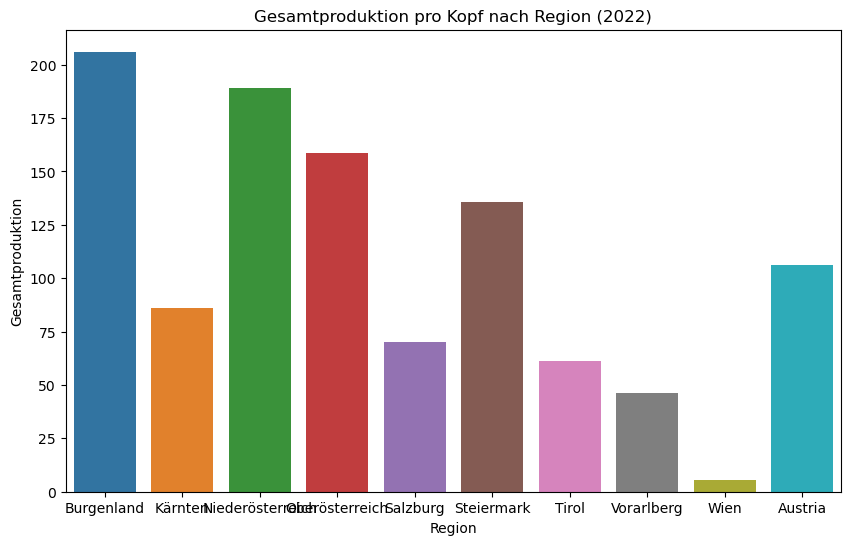

In [22]:
bypop_2022 = bypop_df[bypop_df['Year'] == '2022']

plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Gesamt', data=bypop_2022)

plt.title("Gesamtproduktion pro Kopf nach Region (2022)")
plt.xlabel("Region")
plt.ylabel("Gesamtproduktion")
plt.show()

Bei der Gesamtproduktion pro Kopf steht das Burgenland an der Spitze, während Wien abgeschlagener Letzter ist. Die westlichen Bundesländer - Salzburg, Tirol und Vorarlberg sind alle drei ebenfalls unterdurchschnittlich - selbiges gilt für Kärnten.

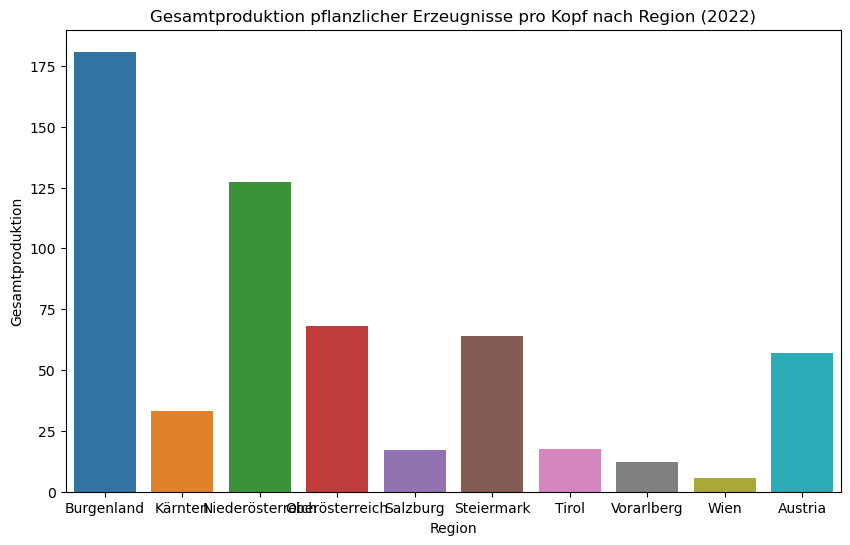

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Pflanzlich', data=bypop_2022)

plt.title("Gesamtproduktion pflanzlicher Erzeugnisse pro Kopf nach Region (2022)")
plt.xlabel("Region")
plt.ylabel("Gesamtproduktion")
plt.show()

In Anbetracht der beiden letzten Statistiken steht das Burgenland wenig überraschend auf Platz 1 bei der Gesamtproduktion pflanzlicher Erzeugnisse, immerhin ist es nach Wien das Bundesland, welches die höchsten prozentuellen Anteil an pflanzlicher Erzeugnis hat und steht bei den Gesamterzeugnissen an 1. Stelle. Wien unterdessen rangiert trotz prozentuell hohen Zahlen, aufgrund der enorm hohen Bevölkerung auch hier an letzter Stelle.
Die westlichsten Bundesländer - Salzburg, Tirol und Vorarlberg liegen allesamt ebenfalls unter dem Durchschnitt.

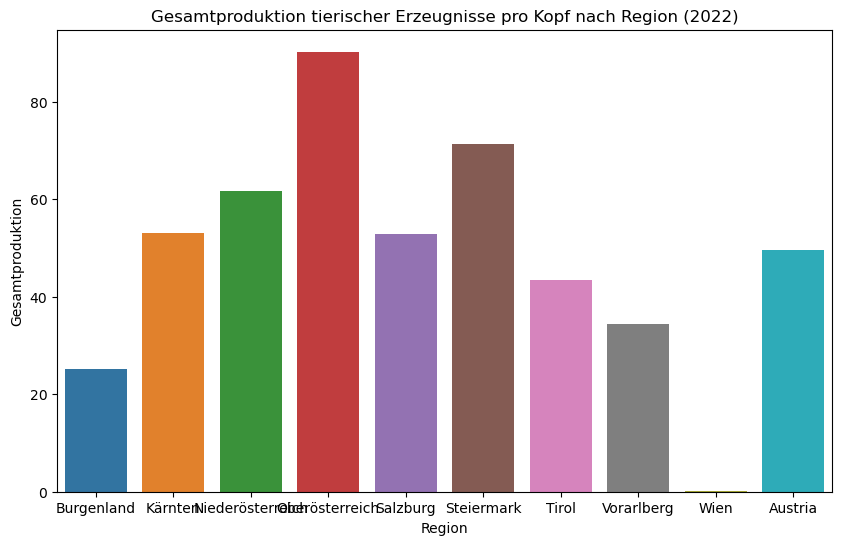

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Tierisch', data=bypop_2022)

plt.title("Gesamtproduktion tierischer Erzeugnisse pro Kopf nach Region (2022)")
plt.xlabel("Region")
plt.ylabel("Gesamtproduktion")
plt.show()

Bei den tierischen Erzeugnissen sieht die Welt schon ganz anders aus. Hier führt Oberösterreich trotz des zuvor erwähnten Abfalls an prozentueller tierischer Produktion in der Pro Kopf Statistik an. Das Burgenland liegt hier von den Flächen-Bundesländern an letzter Stelle. Lediglich Wien, welches im kaum messbaren Bereich liegt fällt hier stark ab. Die meisten tierische Erzeugnisse pro Kopf werden in Oberösterreich produziert, gefolgt von der Steiermark. Die Zahlen der tierischen Produktion liegen in der Spitze jedoch deutlich unter denen der pflanzlichen Erzeugnisse.

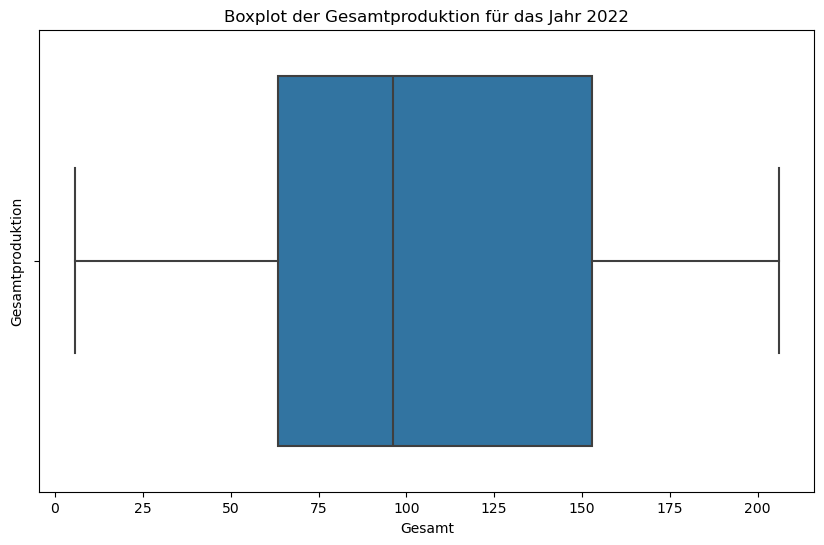

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gesamt', data=bypop_2022)

plt.title("Boxplot der Gesamtproduktion für das Jahr 2022")
plt.ylabel("Gesamtproduktion")

plt.show()

Wie bei diesem Boxplot zu erkennen, liegt der Durchschnitt der Gesamtproudktion bei knapp unter 100. Der Maximalwert liegt bei über 200, während der Wiener Minimalwert bei ca. 10 liegt. Aufgrund der geringen Datenanzahl 10 ist der Boxplot jedoch nicht allzu aussagekräftig.

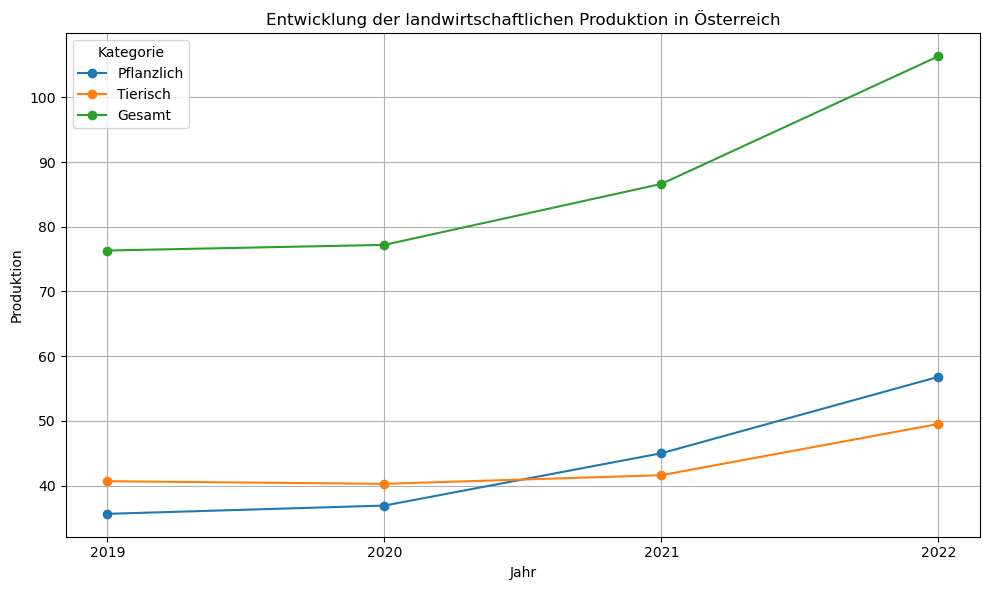

In [26]:
austria_df = bypop_df[bypop_df['Region'] == 'Austria']

plt.figure(figsize=(10, 6))
plt.plot(austria_df['Year'], austria_df['Pflanzlich'], label='Pflanzlich', linestyle='-', marker='o')
plt.plot(austria_df['Year'], austria_df['Tierisch'], label='Tierisch', linestyle='-', marker='o')
plt.plot(austria_df['Year'], austria_df['Gesamt'], label='Gesamt', linestyle='-', marker='o')

plt.title("Entwicklung der landwirtschaftlichen Produktion in Österreich")
plt.xlabel("Jahr")
plt.ylabel("Produktion")
plt.legend(title='Kategorie')
plt.grid(True)

plt.tight_layout()
plt.show()

In Fragen der Selbstversorgung zeigt die Tendenz ganz klar in die richtige Richtung für Österreich. Die Produktion pro Kopf stieg zuletzt in beiden Kategorien an. In der Kategorie der pflanzlichen Produkte zwar stärker, allerdings zeigt auch die Entwicklung der tierischen Produkte nach oben, insbesondere ist ein starker Sprung von 2021 auf 2022 zu beobachten.
Dies passiert trotz des anhaltenden Bevölkerungswachstums in Österreich.

## Gesamt-Fazit

Die Österreichische Bevölkerung steigt, die landwirtschaftliche Produktion steigt allerdings stärker, das ist das erste Fazit, das man aus der Verschneidung der Daten entdecken kann. Dies ist für die österreichische Selbstversorgung ein positiver Indikator. Ob Österreich allerdings sich dauerhaft selbst versorgen kann, hängt weiterhin von einer Vielzahl anderer Faktoren ab, welche nicht Teil dieser Untersuchung war.

Ebenfalls konnte ein starker Unterschied zwischen den einzelnen Bundesländern festgestellt werden. Während es in Wien keine der hohen Bevölkerung angemessene landwirtschaftliche Produktion gibt, sieht das insbesondere in den Bundesländern um Wien (Burgenland und Niederösterreich) anders aus. Hier boomt vor allem die pflanzliche Produktion.

In den westlichereren Bundesländern liegt das Produktionsniveau deutlich unter jenem des Osten und der Fokus liegt deutlich stärker auf der Produktion von tierischen Erzeugnissen. Ein möglicher Hintergrund hierbei könnte das Terrain sein, beheimatet der Westen doch die Mehrheit der österreichischen Alpen, während der Osten deutlich flacher ist. Weitere Faktoren die die Ergebnisse beinflussen können Temperatur-Daten, Klima-Daten und Wasser-Daten sein.

## Export

### Reddis

### JSON

### CSV